In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import boto3
import psycopg2
import configparser

In [63]:
config = configparser.ConfigParser()
config.read('config.cfg')

['config.cfg']

In [64]:
RDS_HOST = 'tienda-transactional.cjykcg6gmirx.us-east-2.rds.amazonaws.com'
print(RDS_HOST)

tienda-transactional.cjykcg6gmirx.us-east-2.rds.amazonaws.com


In [65]:
postgres_driver = f"""postgresql://{config.get('TRANSACC', 'DB_USER')}:{config.get('TRANSACC', 'DB_PASSWORD')}@{RDS_HOST}:{config.get('TRANSACC', 'DB_PORT')}/{config.get('TRANSACC', 'DB_NAME')}"""

#### Pregunta No. 1:
Análisis de ventas por categoría de artículo: ¿Cuáles son las categorías de artículo más vendidas?

#### Primero se importa la tabla de ventas


In [52]:
data_Detalles_Venta = pd.read_csv('dimDetalleVenta.csv')
data_Detalles_Venta

,iddetalle_venta,cantidad,precio,descuento,tipo_comprobante,serie_comprobante,num_comprobante,fecha,impuesto,total,estado_venta,idcategoria,codigo,nombre,precio_venta,stock,descripcion,imagen,estado_articulo
0,4096006,65,573.12,357.44,Ticket de Venta,7805814,56113962,2023-04-07,52.59,37535.91,Reembolsada,40879,MZybOuGz,Perfume Public,573.12,7,Artículo Perfume Public en venta en tienda,fig_398,1
1,7549374,43,573.12,114.24,Ticket de Venta,3302553,88423546,2018-02-22,21.09,28862.28,En proceso,40879,MZybOuGz,Perfume Public,573.12,7,Artículo Perfume Public en venta en tienda,fig_398,1
2,5146385,27,573.12,683.13,Recibo,3827757,97994785,2016-10-11,92.32,55265.83,Completada,40879,MZybOuGz,Perfume Public,573.12,7,Artículo Perfume Public en venta en tienda,fig_398,1
3,5947354,26,573.12,825.77,Ticket de Venta,8606440,34222761,2020-12-13,55.19,20974.22,Reembolsada,40879,MZybOuGz,Perfume Public,573.12,7,Artículo Perfume Public en venta en tienda,fig_398,1
4,3973137,87,573.12,789.20,Nota de Débito,9532676,66856154,2015-11-17,70.69,61993.96,Cancelada,40879,MZybOuGz,Perfume Public,573.12,7,Artículo Perfume Public en venta en tienda,fig_398,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,6255404,24,641.86,704.27,Recibo,3777339,99185410,2020-03-31,94.11,57554.64,Reembolsada,51470,htJDIcNk,Juguete Officer,641.86,74,Artículo Juguete Officer en venta en tienda,fig_130,1
4996,8370819,38,823.77,726.39,Boleta de Venta,7872997,19906961,2018-03-30,99.00,33569.60,En proceso,75369,M9xq0QgN,Teléfono Available,823.77,2,Artículo Teléfono Available en venta en tienda,fig_353,1
4997,5683501,72,911.30,749.01,Ticket de Venta,5171797,70806013,2018-07-07,73.70,39597.27,Pendiente,82016,pTy8a2xc,Tenis Beat,911.30,2,Artículo Tenis Beat en venta en tienda,fig_412,1
4998,6211525,43,865.75,235.92,Ticket de Venta,7965513,42928907,2023-11-12,2.88,94129.24,Cancelada,40879,ithGlQe0,Maquillaje Fight,865.75,78,Artículo Maquillaje Fight en venta en tienda,fig_314,1


In [53]:
data_Detalles_Venta.columns

Index(['iddetalle_venta', 'cantidad', 'precio', 'descuento',
       'tipo_comprobante', 'serie_comprobante', 'num_comprobante', 'fecha',
       'impuesto', 'total', 'estado_venta', 'idcategoria', 'codigo', 'nombre',
       'precio_venta', 'stock', 'descripcion', 'imagen', 'estado_articulo'],
      dtype='object')

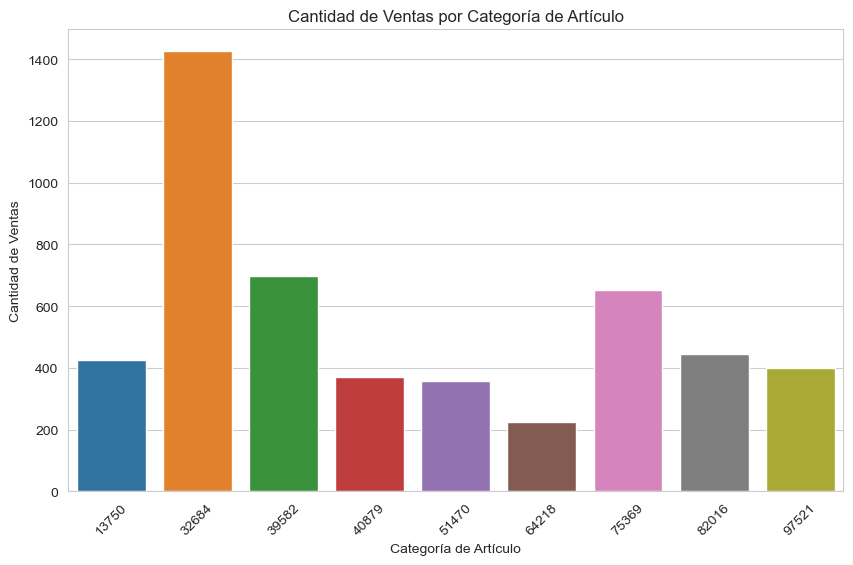

In [54]:
# Crear el gráfico usando Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=data_Detalles_Venta, x='idcategoria')
plt.title('Cantidad de Ventas por Categoría de Artículo')
plt.xlabel('Categoría de Artículo')
plt.ylabel('Cantidad de Ventas')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mejor legibilidad
plt.show()

#### Pregunta No. 2
 ¿Cómo varía el total de ventas entre estas categorías? 
 

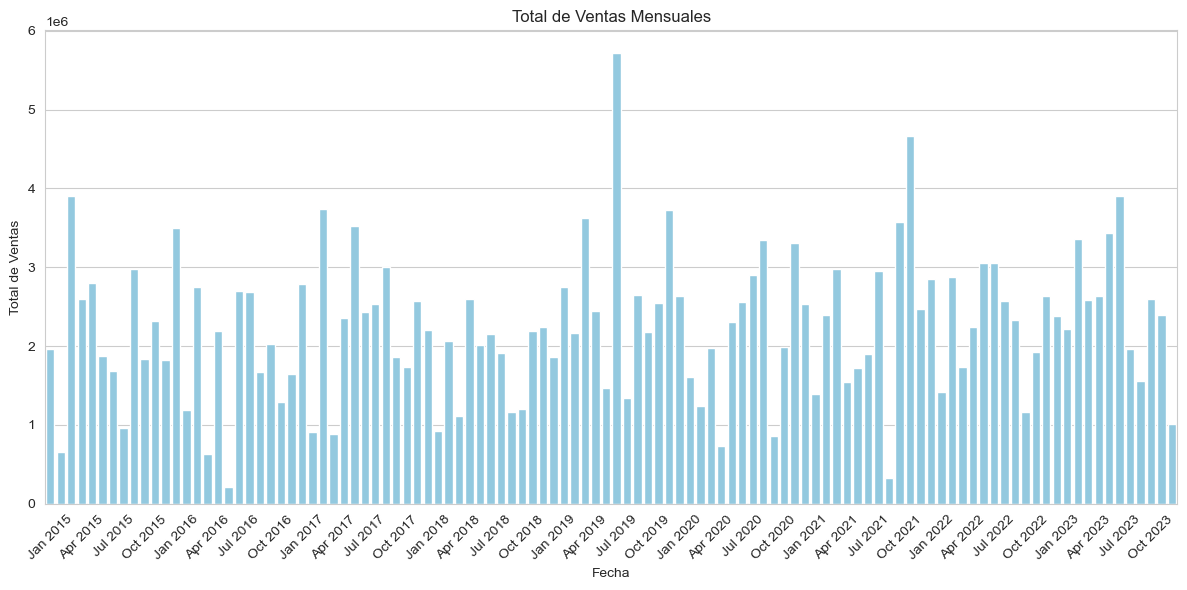

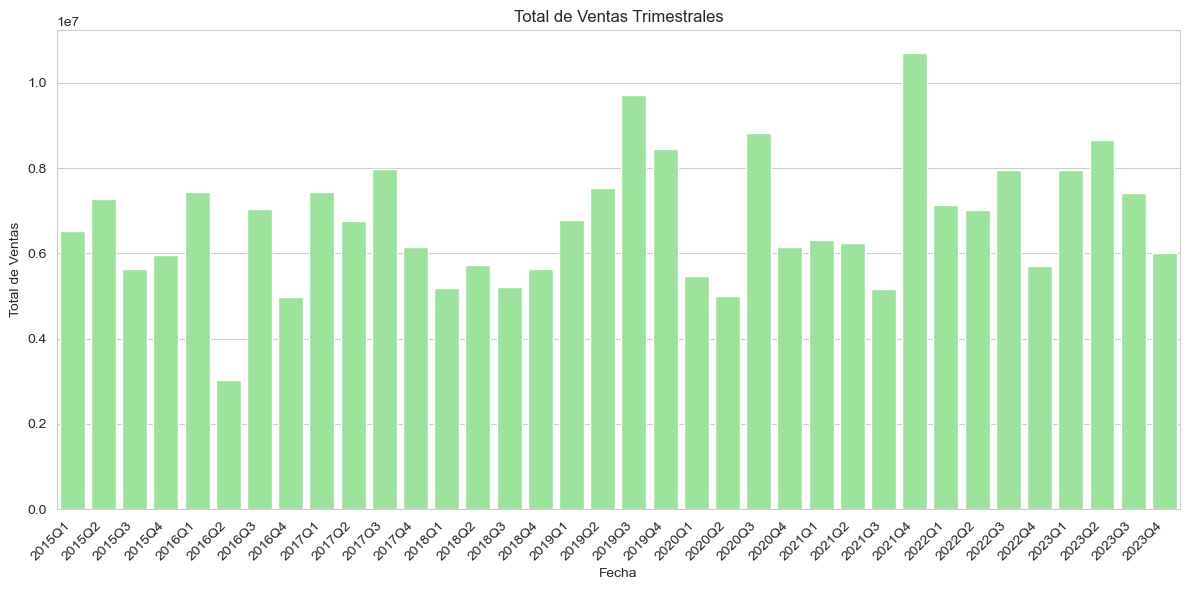

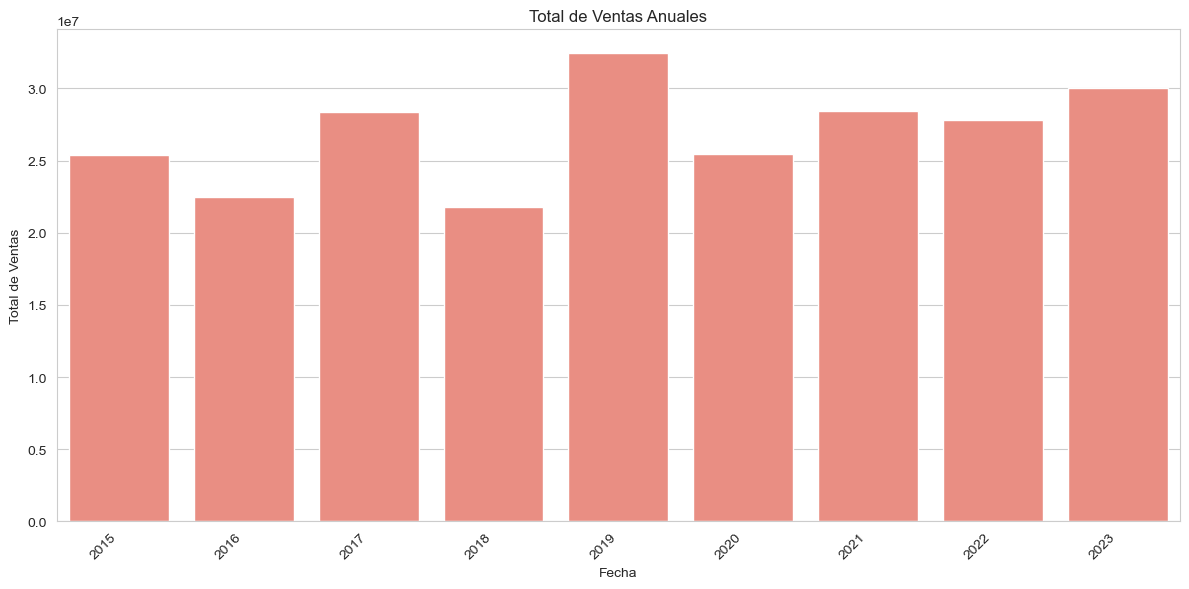

In [55]:
# Convertir la columna 'fecha' a tipo datetime
data_Detalles_Venta['fecha'] = pd.to_datetime(data_Detalles_Venta['fecha'])

# Agrupar las ventas por mes y sumar el total de ventas para cada mes
ventas_mensuales = data_Detalles_Venta.groupby(pd.Grouper(key='fecha', freq='M')).agg({'total': 'sum'}).reset_index()

# Agrupar las ventas por trimestre y sumar el total de ventas para cada trimestre
ventas_trimestrales = data_Detalles_Venta.groupby(pd.Grouper(key='fecha', freq='Q')).agg({'total': 'sum'}).reset_index()

# Agrupar las ventas por año y sumar el total de ventas para cada año
ventas_anuales = data_Detalles_Venta.groupby(pd.Grouper(key='fecha', freq='Y')).agg({'total': 'sum'}).reset_index()

# Configurar el estilo de los gráficos de Seaborn
sns.set_style("whitegrid")

# Crear un gráfico de barras agrupadas para las ventas mensuales

# Seleccionar solo cada tercer mes para los ticks del eje x
ticks_seleccionados = ventas_mensuales['fecha'][::3]

plt.figure(figsize=(12, 6))
sns.barplot(x=ventas_mensuales['fecha'].dt.strftime('%b %Y'), y=ventas_mensuales['total'], color='skyblue')
plt.title('Total de Ventas Mensuales')
plt.xlabel('Fecha')
plt.ylabel('Total de Ventas')
# Establecer los ticks del eje x
plt.xticks(ticks=ticks_seleccionados.index, labels=ticks_seleccionados.dt.strftime('%b %Y'), rotation=45, ha='center')
plt.tight_layout()
plt.show()

# Crear un gráfico de barras agrupadas para las ventas trimestrales
plt.figure(figsize=(12, 6))
sns.barplot(x=ventas_trimestrales['fecha'].dt.to_period('Q').astype(str), y=ventas_trimestrales['total'], color='lightgreen')
plt.title('Total de Ventas Trimestrales')
plt.xlabel('Fecha')
plt.ylabel('Total de Ventas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Crear un gráfico de barras agrupadas para las ventas anuales
plt.figure(figsize=(12, 6))
sns.barplot(x=ventas_anuales['fecha'].dt.strftime('%Y'), y=ventas_anuales['total'], color='salmon')
plt.title('Total de Ventas Anuales')
plt.xlabel('Fecha')
plt.ylabel('Total de Ventas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Pregunta No. 3
 ¿Qué rol o roles tienden a tener un mayor impacto en el resultado final de las ventas?
 

In [77]:
sql_query = 'SELECT * FROM venta;'
df_venta = pd.read_sql(sql_query, postgres_driver)
df_venta = df_venta.rename(columns={'estado': 'estado_venta'})
df_venta.head()

,idventa,idcliente,idusuario,tipo_comprobante,serie_comprobante,num_comprobante,fecha,impuesto,total,estado_venta
0,440324,161533493,5132316,Ticket de Venta,9392128,60010496,2017-04-25,33.73,30667.30,En proceso
1,886789,827908426,1502402,Boleta de Venta,6043652,91457537,2016-09-28,40.77,69801.72,Cancelada
2,747524,452401638,6895673,Ticket de Venta,2856965,67110914,2023-02-08,7.35,24363.43,Reembolsada
3,718855,516310396,3812010,Nota de Débito,5607430,75182086,2018-01-16,92.66,39454.25,Cancelada
4,882698,976254212,5491956,Nota de Débito,8556551,67856392,2023-06-27,57.23,61716.32,Cancelada


In [78]:
sql_query = 'SELECT * FROM persona'
df_cliente = pd.read_sql(sql_query, postgres_driver)
df_cliente = df_cliente[df_cliente['tipo_persona']=='cliente']
df_cliente = df_cliente.rename(columns={'idpersona': 'idcliente', 'nombre': 'nombre_cliente', 'tipo_documento': 'tipo_documento_cliente', 'num_documento': 'num_documento_cliente','direccion': 'direccion_cliente', 'telefono': 'telefono_cliente', 'email': 'email_cliente'})
df_cliente.head()

,idcliente,tipo_persona,nombre_cliente,tipo_documento_cliente,num_documento_cliente,direccion_cliente,telefono_cliente,email_cliente
0,463292416,cliente,Desiree Diaz,Pasaporte,147682912346113,"9238 Owens Land Suite 734 North Gabriel, NH 77058",+1-686-8,wongronald@hotmail.com
6,444735508,cliente,Michelle Henderson,DNI,193064418697232,"65789 Dennis Park Tylerstad, FL 81223",(940)380,tgibson@yahoo.com
7,488015896,cliente,Mr. James Stewart,DNI,168386493718550,"462 Koch Glen Port Michellefort, MT 33005",28880780,angela95@gmail.com
8,716460059,cliente,Nathaniel Barry,Pasaporte,159245248190492,"60490 Kathryn Cliff Suite 043 West Robert, CA ...",91736717,ronaldfoster@gmail.com
11,614416411,cliente,Amanda Hurst,NIE,155071137714219,"6624 Tiffany Junctions Lorimouth, VT 91011",001-586-,qharvey@gmail.com


In [79]:
df_venta_cliente = df_venta.merge(df_cliente, how='inner', on='idcliente')
df_venta_cliente.head()

,idventa,idcliente,idusuario,tipo_comprobante,serie_comprobante,num_comprobante,fecha,impuesto,total,estado_venta,tipo_persona,nombre_cliente,tipo_documento_cliente,num_documento_cliente,direccion_cliente,telefono_cliente,email_cliente
0,747524,452401638,6895673,Ticket de Venta,2856965,67110914,2023-02-08,7.35,24363.43,Reembolsada,cliente,Christopher Powers,NIE,155851439253989,"452 Wise Hollow Apt. 949 Hamptontown, MS 74863",911.689.,yho@gmail.com
1,718855,516310396,3812010,Nota de Débito,5607430,75182086,2018-01-16,92.66,39454.25,Cancelada,cliente,Monica Charles,Tarjeta Residencia,147774982911315,"430 Cain Forges Suite 877 Josephchester, VI 87388",(407)812,chadwheeler@yahoo.com
2,687469,516310396,8745434,Nota de Crédito,6477087,80168172,2022-01-02,87.96,6022.90,En proceso,cliente,Monica Charles,Tarjeta Residencia,147774982911315,"430 Cain Forges Suite 877 Josephchester, VI 87388",(407)812,chadwheeler@yahoo.com
3,772111,475790643,8124808,Boleta de Venta,2994197,75370512,2019-08-21,26.39,24372.48,Completada,cliente,Cindy Williams,NIE,139396824773914,"PSC 0310, Box 5624 APO AP 78701",647.995.,xwilson@yahoo.com
4,593937,955196919,6366513,Ticket de Venta,1034269,79214611,2015-06-14,5.72,40412.01,En proceso,cliente,Brenda Macdonald,NIE,160197191265706,"12028 Brandy Route Apt. 480 Lake Tylerside, PA...",+1-556-6,rguerra@yahoo.com


In [80]:
sql_query = 'SELECT * FROM usuario;'
df_usuario = pd.read_sql(sql_query, postgres_driver)
df_usuario = df_usuario.rename(columns={'nombre': 'nombre_usuario', 'tipo_documento': 'tipo_documento_usuario', 'num_documento': 'num_documento_usuario','direccion': 'direccion_usuario', 'telefono': 'telefono_usuario', 'email': 'email_usuario', 'estado': 'estado_cliente'})
df_usuario.head()

,idusuario,idrol,nombre_usuario,tipo_documento_usuario,num_documento_usuario,direccion_usuario,telefono_usuario,email_usuario,clave,estado_cliente
0,7868418,10004,Luis Warren,Pasaporte,152338746871809,"3080 Travis Freeway Suite 836 Yorkshire, PA 42313",464-312-,lance31@gmail.com,"[b'd', b'9', b'f', b'1', b'5', b'b', b'a', b'9...",0
1,8210435,10004,Kristen Perez,Pasaporte,114070976995330,"854 Rush Ways East Melvinborough, NM 67431",+1-965-6,marcusjones@yahoo.com,"[b'1', b'b', b'1', b'0', b'f', b'f', b'c', b'6...",1
2,6367235,10002,Andrea Carney,DNI,146279382966274,USCGC Campos FPO AE 16169,001-468-,gainesgregory@yahoo.com,"[b'f', b'c', b'c', b'f', b'f', b'9', b'8', b'2...",1
3,1214471,10003,Lori Morrison,NIE,121915984308230,"081 Jill Run Lake Stephanieborough, MT 86103",001-274-,nwilson@hotmail.com,"[b'7', b'7', b'6', b'b', b'7', b'c', b'1', b'9...",1
4,6279175,10001,Jessica Chambers,Pasaporte,126574599972870,"5937 Sylvia Mountain South Shawn, SD 97049",+1-427-3,travismclean@gmail.com,"[b'4', b'1', b'3', b'8', b'b', b'd', b'd', b'7...",0


In [81]:
df_venta_cliente_usuario = df_venta_cliente.merge(df_usuario, how='inner', on='idusuario')
df_venta_cliente_usuario = df_venta_cliente_usuario.drop(['idcliente'], axis=1)
df_venta_cliente_usuario.head()

,idventa,idusuario,tipo_comprobante,serie_comprobante,num_comprobante,fecha,impuesto,total,estado_venta,tipo_persona,...,email_cliente,idrol,nombre_usuario,tipo_documento_usuario,num_documento_usuario,direccion_usuario,telefono_usuario,email_usuario,clave,estado_cliente
0,747524,6895673,Ticket de Venta,2856965,67110914,2023-02-08,7.35,24363.43,Reembolsada,cliente,...,yho@gmail.com,10004,Matthew Brown,NIE,105199439972415,"271 Timothy Crossing North Joseph, VA 16705",(268)240,jameswells@gmail.com,"[b'b', b'b', b'd', b'8', b'6', b'd', b'0', b'7...",1
1,476049,6895673,Nota de Débito,2730880,80659262,2021-08-21,90.76,21327.84,En proceso,cliente,...,rodriguezjody@gmail.com,10004,Matthew Brown,NIE,105199439972415,"271 Timothy Crossing North Joseph, VA 16705",(268)240,jameswells@gmail.com,"[b'b', b'b', b'd', b'8', b'6', b'd', b'0', b'7...",1
2,718855,3812010,Nota de Débito,5607430,75182086,2018-01-16,92.66,39454.25,Cancelada,cliente,...,chadwheeler@yahoo.com,10001,Ruth Brown,NIE,128629693309651,"8620 Howell Cape South Travisstad, MS 77744",(716)989,lewisbrandy@hotmail.com,"[b'9', b'b', b'4', b'f', b'a', b'a', b'f', b'0...",0
3,742112,3812010,Boleta de Venta,4498143,99146405,2019-12-22,70.11,67210.84,Pendiente,cliente,...,sarahjames@yahoo.com,10001,Ruth Brown,NIE,128629693309651,"8620 Howell Cape South Travisstad, MS 77744",(716)989,lewisbrandy@hotmail.com,"[b'9', b'b', b'4', b'f', b'a', b'a', b'f', b'0...",0
4,687469,8745434,Nota de Crédito,6477087,80168172,2022-01-02,87.96,6022.90,En proceso,cliente,...,chadwheeler@yahoo.com,10003,Kimberly Walker,NIE,181462814302696,"74484 Williams Village New Mark, IN 60405",+1-875-8,abrown@hotmail.com,"[b'9', b'7', b'3', b'2', b'd', b'b', b'6', b'1...",0


In [82]:
df_venta_cliente_usuario.columns

Index(['idventa', 'idusuario', 'tipo_comprobante', 'serie_comprobante',
       'num_comprobante', 'fecha', 'impuesto', 'total', 'estado_venta',
       'tipo_persona', 'nombre_cliente', 'tipo_documento_cliente',
       'num_documento_cliente', 'direccion_cliente', 'telefono_cliente',
       'email_cliente', 'idrol', 'nombre_usuario', 'tipo_documento_usuario',
       'num_documento_usuario', 'direccion_usuario', 'telefono_usuario',
       'email_usuario', 'clave', 'estado_cliente'],
      dtype='object')

In [83]:
data_roles = pd.read_csv('dimRol.csv')
data_roles.head()

,idrol,nombre,descripcion,estado
0,10001,Administrador,Este rol tiene acceso completo al sistema y pu...,1
1,10002,Moderador,Este rol tiene permisos para moderar contenido...,1
2,10003,Usuario Estándar,Este rol tiene acceso limitado y puede realiza...,1
3,10004,Soporte Técnico,Este rol proporciona soporte técnico y tiene a...,1
4,10005,Invitado,Este rol tiene acceso limitado y solo puede ve...,1


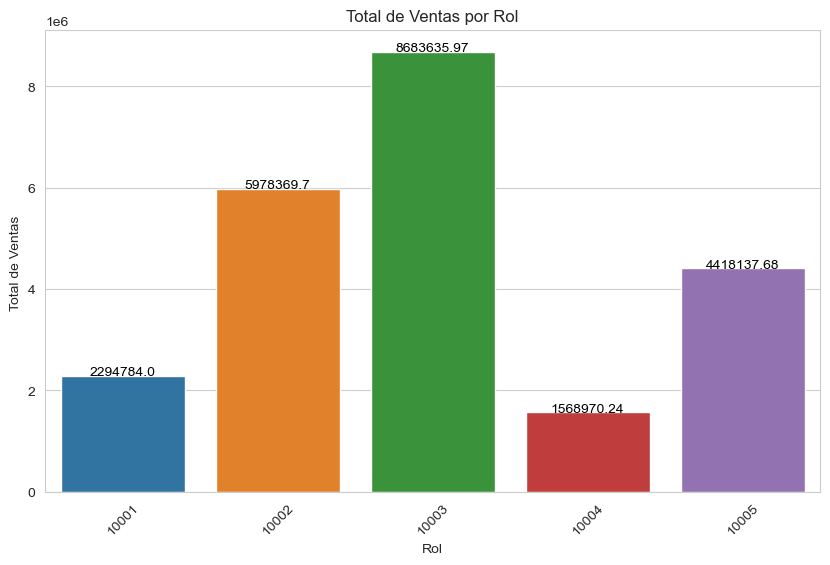

In [91]:
# Paso 1: Relacionar los datos de ventas con los datos de usuarios
#ventas_usuarios = pd.merge(df_venta_cliente_usuario, df_usuario, how='left', on='idusuario')

# Paso 2: Relacionar los datos de usuarios con los roles
usuarios_roles = pd.merge(df_venta_cliente_usuario, data_roles, how='left', on='idrol')

# Paso 3: Calcular el total de ventas por rol
ventas_por_rol = usuarios_roles.groupby('idrol')['total'].sum().reset_index()

# Paso 4: Visualizar los resultados
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='idrol', y='total', data=ventas_por_rol.sort_values(by='total', ascending=False))
plt.xlabel('Rol')
plt.ylabel('Total de Ventas ')
plt.title('Total de Ventas por Rol')
plt.xticks(rotation=45)

# Agregar etiquetas de texto en las barras
for index, row in ventas_por_rol.iterrows():
    ax.text(index, row['total'], str(round(row['total'], 2)), color='black', ha="center")

plt.show()

#### Pregunta No. 4
 ¿Cómo varían las ventas en diferentes momentos del año, como durante las vacaciones o eventos especiales? #Semana Santa

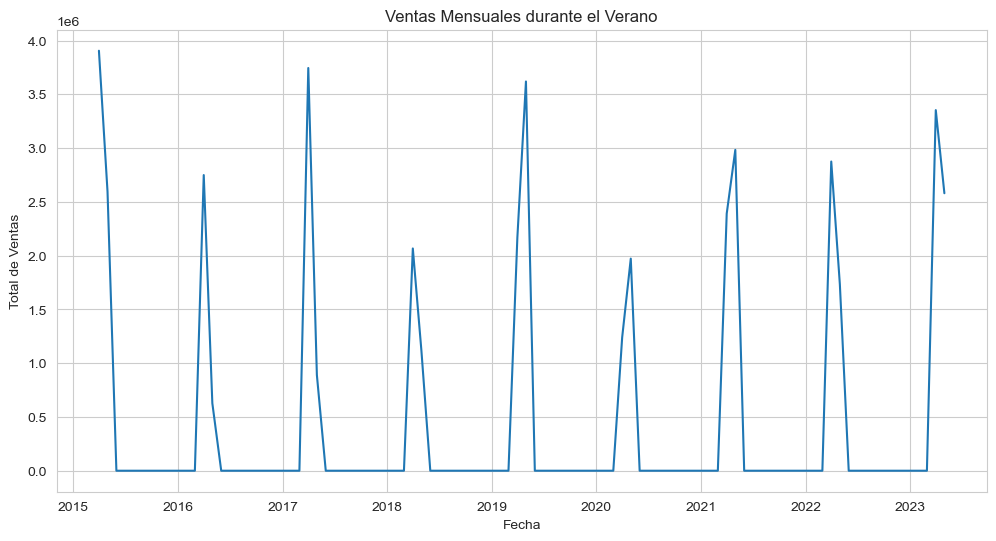

In [92]:
# Paso 1: Identificar los períodos de interés (por ejemplo, las ventas durante las vacaciones de verano)
ventas_verano = data_Detalles_Venta[(data_Detalles_Venta['fecha'].dt.month >= 3) & (data_Detalles_Venta['fecha'].dt.month <= 4)]

# Paso 2: Agrupar las ventas por mes y calcular el total de ventas para cada mes durante el verano
ventas_verano_mensuales = ventas_verano.groupby(pd.Grouper(key='fecha', freq='M')).agg({'total': 'sum'}).reset_index()

# Paso 3: Visualizar los datos
plt.figure(figsize=(12, 6))
sns.lineplot(x='fecha', y='total', data=ventas_verano_mensuales)
plt.title('Ventas Mensuales durante el Verano')
plt.xlabel('Fecha')
plt.ylabel('Total de Ventas')
plt.show()

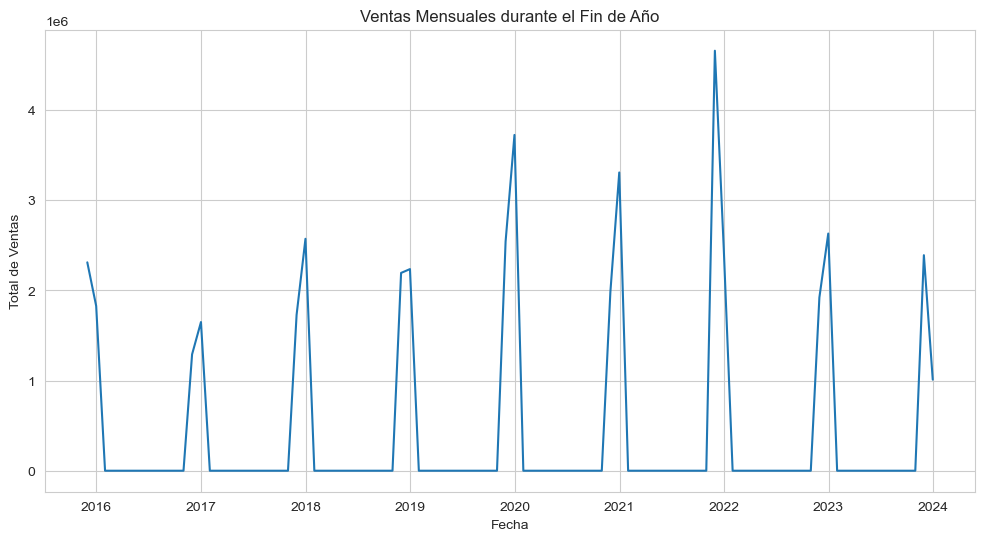

In [93]:
# Paso 1: Identificar los períodos de interés (por ejemplo, las ventas durante las vacaciones de verano)
ventas_fin_de_anio = data_Detalles_Venta[(data_Detalles_Venta['fecha'].dt.month >= 11) & (data_Detalles_Venta['fecha'].dt.month <= 12)]

# Paso 2: Agrupar las ventas por mes y calcular el total de ventas para cada mes durante el verano
ventas_fin_de_anio_mensuales = ventas_fin_de_anio.groupby(pd.Grouper(key='fecha', freq='M')).agg({'total': 'sum'}).reset_index()

# Paso 3: Visualizar los datos
plt.figure(figsize=(12, 6))
sns.lineplot(x='fecha', y='total', data=ventas_fin_de_anio_mensuales)
plt.title('Ventas Mensuales durante el Fin de Año')
plt.xlabel('Fecha')
plt.ylabel('Total de Ventas')
plt.show()

#### Pregunta No. 5
 ¿Cómo varían las ventas en diferentes momentos del año, como durante las vacaciones o eventos especiales? Navidad
 

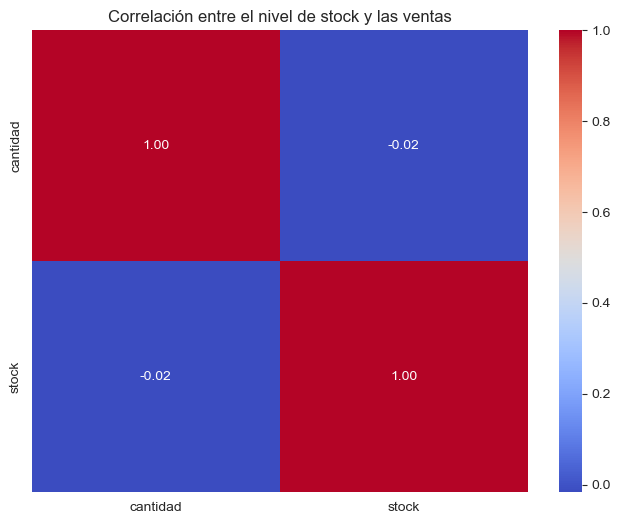

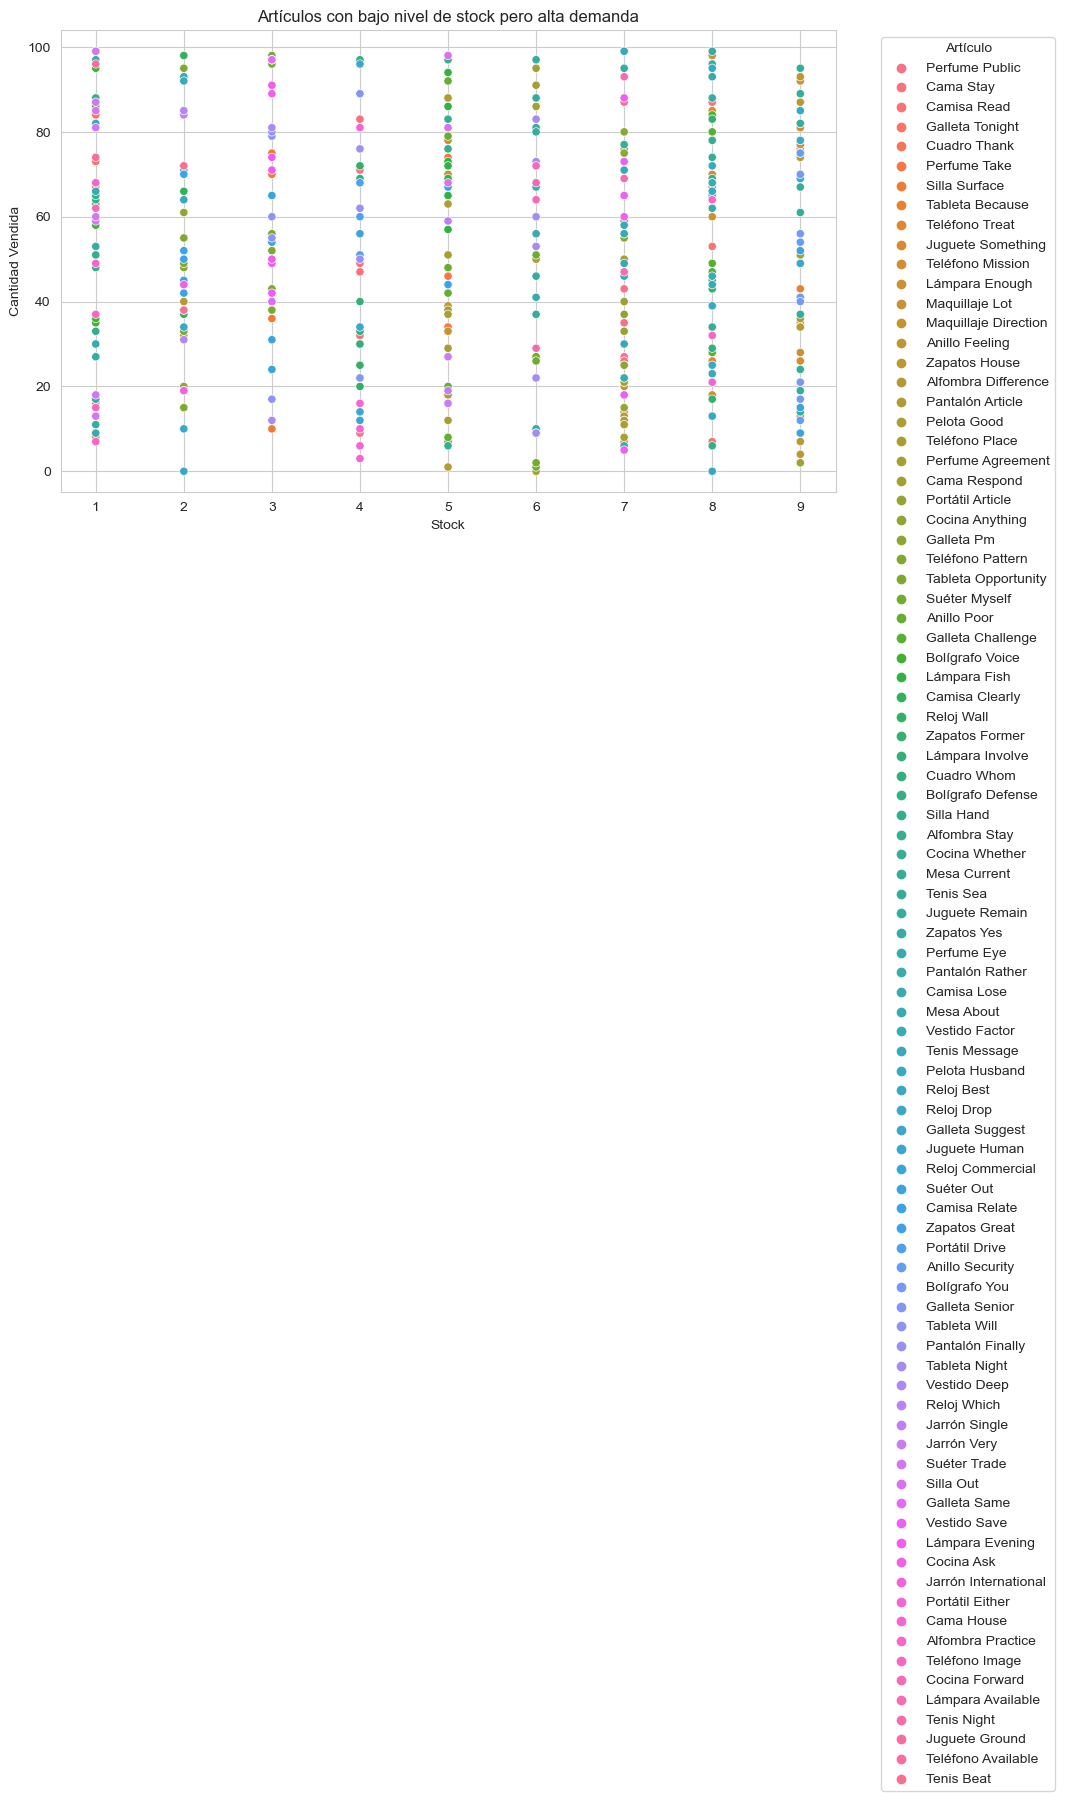

In [94]:
# Correlación entre el nivel de stock y las ventas
correlation = data_Detalles_Venta[['cantidad', 'stock']].corr()

# Identificar artículos con bajo nivel de stock pero alta demanda
# Filtrar los artículos con stock bajo
low_stock_items = data_Detalles_Venta[data_Detalles_Venta['stock'] < 10]  # Por ejemplo, artículos con menos de 10 unidades en stock

# Filtrar los artículos con alta demanda (por ejemplo, los más vendidos)
high_demand_items = data_Detalles_Venta[data_Detalles_Venta['cantidad'] > data_Detalles_Venta['cantidad'].mean()]  # Artículos que se vendieron más que el promedio

# Visualización de la correlación entre el nivel de stock y las ventas
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlación entre el nivel de stock y las ventas')
plt.show()

# Visualización de los artículos con bajo nivel de stock pero alta demanda
plt.figure(figsize=(10, 6))
sns.scatterplot(data=low_stock_items, x='stock', y='cantidad', hue='nombre')
plt.title('Artículos con bajo nivel de stock pero alta demanda')
plt.xlabel('Stock')
plt.ylabel('Cantidad Vendida')
plt.legend(title='Artículo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()